In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import scipy
import os
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"]="6"

device = torch.device("cuda:0")

torch.manual_seed(0)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
weight_path = "ResNet18"
model.load_state_dict(torch.load(weight_path, map_location=device))
model = model.to(device)
model.eval()

df_training = pd.read_json("/export/gaon1/data/jteneggi/data/malaria/training.json")
df_test = pd.read_json("/export/gaon1/data/jteneggi/data/malaria/test_cropped.json")
frames = [df_training, df_test]
df_merged = pd.concat(frames, ignore_index=True)
# ADD IMAGE_NAME COLUMN TO DATAFRAME
image_names = []
for i, row in df_merged.iterrows():
    image_names.append(os.path.basename(row["image"]["pathname"]))
df_merged["image_name"] = image_names


transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize([0.7206, 0.7204, 0.7651], [0.2305, 0.2384, 0.1706])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = "/export/gaon1/data/jteneggi/data/malaria/trophozoite"
dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform)
image_names = [os.path.basename(sample[0]) for sample in dataset.samples]
print(len(image_names))
true_positives = {}
for c in np.arange(1, 11):
    true_positives[str(c)] = []
print(true_positives)
false_positives = []
false_negatives = []
true_negatives = []
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, num_workers=0)
for batch_id, (images, labels) in enumerate(dataloader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    np_labels = labels.cpu().numpy()
    np_preds = preds.detach().cpu().numpy()
    print(np_labels, np_preds)
    
    for i, label in enumerate(np_labels):
        image_id = batch_id * 4 + i
        image_name = image_names[image_id]
        image = os.path.join(data_dir, "test/{}/{}".format(label, image_name))
        if label == 0:
            if np_preds[i] == 0:
                true_negatives.append(image)
            if np_preds[i] == 1:
                false_positives.append(image)
        if label == 1:
            if np_preds[i] == 1:
                trophozoite_count = 0
                query = df_merged.loc[df_merged["image_name"] == image_name]
                for _, row in query.iterrows():
                    cells = row["objects"]
                    for cell in cells:
                        if cell["category"] == "trophozoite":
                            trophozoite_count += 1
                true_positives[str(trophozoite_count)].append(image)
            if np_preds[i] == 0:
                false_negatives.append(image)
np.save("true_positives.npy", true_positives)
print("done")

229
{'1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': [], '10': []}
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [1 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 1]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [1 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 1 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 1 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 1 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 1]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[0 0 0 0] [0 0 0 0]
[1 1 1 1] [1 1 1 1]
[1 1 1 1] [1 1 1 1]
[1 1 1 1] [1 1 1 0]
[1 1 1 1] [1 1 1 1]
[1 1 1 1] [1 1 1 1]
[1 1 1 1] [1 1 1 1]
[1 1 1 1] [1 1 1 1]
[1 1 1 1] [1 1 1 1]
[1 1 1 1] [1 1 1 1]
[1 1 1 1] [1 1 1 1]
[1 1 1 1] [1 1 1 1]
[1 1 1 1] [0 1 1 1]
[1 1 1 1] [1 1 1 1]
[1 1 1 1] [1 1 1 1]
[1 1 1 1] [1 1 1 1]
[1 1 1 1] [1 1 1 1]
[1 1

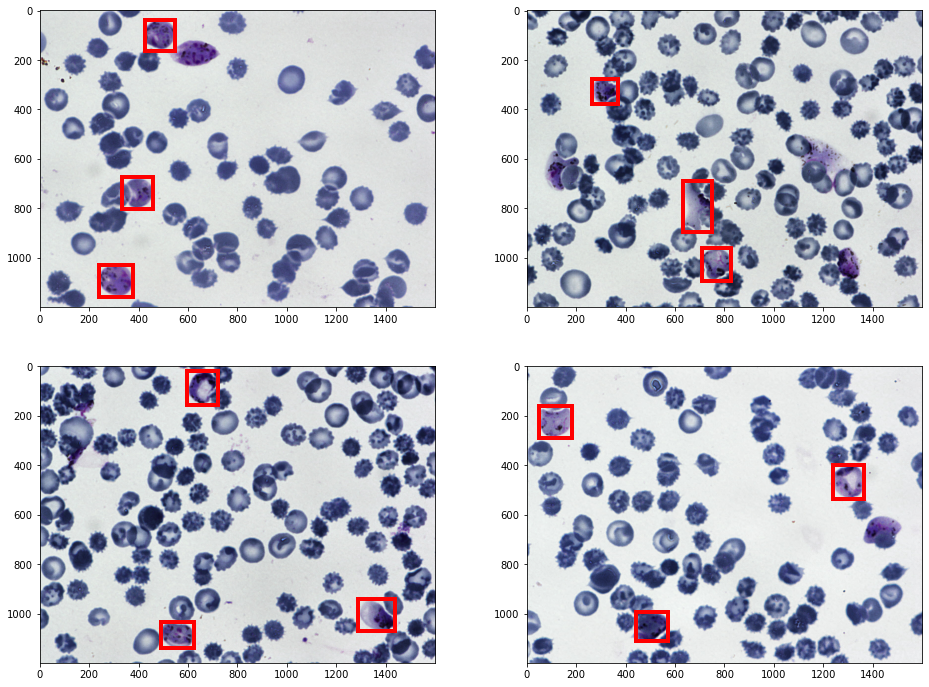

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import matplotlib.patches as patches


fig = plt.figure(figsize=(16, 12))
axes = fig.subplots(2, 2)
for i, image in enumerate(np.random.choice(true_positives["1"], size=4, replace=False)):
    img = Image.open(image)
    ax = axes[int(i/2), i%2]
    ax.imshow(img)
    image_name = os.path.basename(image)
    query = df_merged.loc[df_merged["image_name"] == image_name]
    for i, row in query.iterrows():
        cells = row["objects"]
        for cell in cells:
            cell_class = cell["category"]
            if cell_class == "trophozoite":
                bbox = cell["bounding_box"]
                upper_left_r = bbox["minimum"]["r"]
                upper_left_c = bbox["minimum"]["c"]
                lower_right_r = bbox["maximum"]["r"]
                lower_right_c = bbox["maximum"]["c"]
                w = np.abs(lower_right_c - upper_left_c)
                h = np.abs(lower_right_r - upper_left_r)
                # Create a Rectangle patch
                rect = patches.Rectangle((upper_left_c,upper_left_r),w,h,linewidth=4,edgecolor='r',facecolor='none')
                # Add the patch to the Axes
                ax.add_patch(rect)

In [3]:
correct = 0
wrong = 0
for c in true_positives:
    print(c, len(true_positives[c]))
    correct += len(true_positives[c])
correct += len(true_negatives)
wrong += len(false_negatives)
wrong += len(false_positives)
print(correct/(correct+wrong), correct+wrong)

1 40
2 23
3 16
4 13
5 5
6 2
7 2
8 4
9 1
10 1
0.9432314410480349 229
